### Переходим к практике

In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)


(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [4]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [5]:
import regex
import itertools
# word_regex = regex.compile(r"\w+",  regex.VERBOSE | regex.I | regex.UNICODE)  

In [6]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [7]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [8]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1] токенизация предложения через razdel
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2] проверка есть ли в начале слова '-'
            w = w[1:]
        if len(w)>1: # [3] проверка токена с одного символа
            if w in cache: # [4] проверка есть ли данное слово в кэше
                words_lem.append(cache[w])
            else: # [5] лемматизация слова
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]проверка на стоп-слова
    
    return words_lem_without_stopwords

In [10]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

Wall time: 31.7 s


In [11]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 28s


А теперь в 3 строчки обучим нашу модель

In [12]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [13]:
common_dictionary[10]

'ватутин'

Все просто - это словарь наших слов

Запускаем обучение

In [14]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 50.6 s


In [15]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [16]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(5, 0.13455512),
 (14, 0.23038526),
 (15, 0.05918182),
 (18, 0.20108563),
 (19, 0.3536032)]

In [17]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: военный наука совет решение россия земля глава
topic_1: проект строительство площадь участок маршрут построить метр
topic_2: иск выделить лекарство подать австралийский свердловский снежный
topic_3: ракета риск система цена температура двигатель рост
topic_4: земля nn доллар метод товар доля цена
topic_5: пенсия конкурс больной катастрофа девочка знаменитый высота
topic_6: мозг пациент врач лечение nn договор страдать
topic_7: турция турецкий энергия южный северный офицер удар
topic_8: исследование фонд журнал запустить университет лаборатория рейтинг
topic_9: россия российский млрд новый первый nn научный
topic_10: поверхность бежать расстояние водитель молдавия показ передовой
topic_11: рубль млн тыс статья дом размер nn
topic_12: день nn россия российский всё первый сша
topic_13: район тело обнаружить произойти пострадать вода nn
topic_14: ребёнок всё жизнь первый очень nn большой
topic_15: путин остров миссия смерть японский владимир пресссекретарить
topic_16: банк убийств

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [18]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [19]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.753015,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.16629,0.0,0.052337,0.000000,0.020435,0.0,0.0,0.0,0.0
1,4896,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.00000,0.0,0.191949,0.783821,0.000000,0.0,0.0,0.0,0.0
2,4897,0.000000,0.0,0.000000,0.000000,0.0,0.134552,0.0,0.0,0.0,...,0.059175,0.00000,0.0,0.201077,0.353585,0.000000,0.0,0.0,0.0,0.0
3,4898,0.000000,0.0,0.026194,0.014825,0.0,0.000000,0.0,0.0,0.0,...,0.022036,0.00000,0.0,0.083482,0.000000,0.000000,0.0,0.0,0.0,0.0
4,4899,0.798813,0.0,0.000000,0.000000,0.0,0.093539,0.0,0.0,0.0,...,0.000000,0.00000,0.0,0.000000,0.000000,0.081738,0.0,0.0,0.0,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [20]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [21]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [22]:
len(doc_dict[325])

25

In [23]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [24]:
all_articles_read = np.array([eval(user) for user  in users.articles])
all_articles_read.shape

(8000, 6)

In [25]:
users.articles

0       [293672, 293328, 293001, 293622, 293126, 1852]
1               [3405, 1739, 2972, 1158, 1599, 322665]
2               [1845, 2009, 2356, 1424, 2939, 323389]
3               [5933, 6186, 5055, 6977, 5206, 488389]
4                [707, 1144, 2532, 2928, 3133, 324592]
                             ...                      
7995     [323918, 323362, 323704, 323452, 324291, 251]
7996            [5532, 5860, 7755, 7140, 5182, 488337]
7997    [322811, 323898, 321858, 323345, 323491, 2193]
7998            [5436, 6092, 6891, 7045, 5320, 487379]
7999    [294096, 293759, 294178, 293544, 293921, 2909]
Name: articles, Length: 8000, dtype: object

# Tfidf

Я попробовал воспользоваться библиотекой sklearn для tfidf, но видимо я что-то делал нетак, потому что у меня потерялась часть статей.

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [27]:
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(users.articles)

<8000x14781 sparse matrix of type '<class 'numpy.float64'>'
	with 47957 stored elements in Compressed Sparse Row format>

In [28]:
features = vectorizer.get_feature_names()
print(len(features))

14781


In [29]:
doc_idf = dict(zip(features, vectorizer.idf_))

я реализовал собственный idf, что не сложно.

In [159]:
all_articles_read = all_articles_read.ravel() 
unique, counts = np.unique(all_articles_read, return_counts=True)
d = dict(zip(unique, counts))
sorted(d, key=lambda x: d[x])
length= len(d)
for key in d:
    d[key]= np.log(length/(d[key])

In [167]:
length, len(doc_idf)

(14787, 14781)

Как мы видим в моем idf словаре на 6 ключей больше, не совсем понимаю куда они потерялсть в sklern модели.

Переделал get_user_embedding так, что она стала принимать 2 ключа, один np_method - функция для подсчета предпочтений за 6 статей "суммарно". И флаг idf = false or true, который отвечает за использование статей с учетом idf и без.

In [141]:
user_articles_list = users['articles'].iloc[3]

def get_user_embedding(user_articles_list, np_method=np.mean, idf = False):

    user_articles_list = eval(user_articles_list)
    if idf:
        user_vector = np.array([doc_dict[doc_id] * d[doc_id] for doc_id in user_articles_list])
    else:
        user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np_method(user_vector, 0)
    return user_vector

In [121]:
get_user_embedding(user_articles_list, np.mean)

array([0.08261325, 0.        , 0.        , 0.04014079, 0.01663666,
       0.        , 0.00363629, 0.00310452, 0.        , 0.05360485,
       0.00932135, 0.        , 0.06565828, 0.00348298, 0.26235554,
       0.        , 0.        , 0.0414729 , 0.2528468 , 0.03989835,
       0.        , 0.        , 0.        , 0.00464971, 0.10647387])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [122]:
#users['articles'].iloc[33]

In [123]:
#" ".join(news[news['doc_id']==323186]['title'].iloc[0])

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [124]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, np_method=np.max), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.113166,0.267170,0.034411,0.000000,0.336763,0.088186,0.079114,0.000000,0.000000,...,0.282940,0.030981,0.467601,0.000000,0.160687,0.127664,0.207778,0.079838,0.014822,0.000000
1,u108690,0.228328,0.000000,0.000000,0.033438,0.042342,0.021556,0.117910,0.000000,0.000000,...,0.112681,0.145249,0.161815,0.000000,0.077179,0.090183,0.048470,0.034935,0.033538,0.027364
2,u108339,0.225609,0.097039,0.000000,0.074011,0.046999,0.000000,0.143958,0.000000,0.000000,...,0.000000,0.097504,0.147819,0.000000,0.120775,0.012434,0.031372,0.029956,0.040325,0.000000
3,u101138,0.436338,0.000000,0.000000,0.240845,0.083402,0.000000,0.021818,0.018627,0.000000,...,0.000000,0.000000,0.113188,0.503653,0.149608,0.000000,0.000000,0.000000,0.027898,0.499674
4,u108248,0.198796,0.022171,0.023057,0.285974,0.192259,0.000000,0.323214,0.000000,0.031131,...,0.110218,0.039264,0.243871,0.011394,0.473371,0.078659,0.020310,0.052312,0.025760,0.016205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,u107463,0.285783,0.012859,0.031848,0.015453,0.067751,0.099428,0.000000,0.000000,0.105819,...,0.114122,0.101985,0.104985,0.000000,0.000000,0.000000,0.000000,0.000000,0.027248,0.012021
7996,u101241,0.169789,0.000000,0.000000,0.000000,0.229183,0.204762,0.013802,0.000000,0.000000,...,0.020920,0.510463,0.107807,0.373240,0.048607,0.029228,0.013161,0.439585,0.000000,0.000000
7997,u106486,0.407540,0.000000,0.086513,0.038251,0.019436,0.000000,0.310860,0.000000,0.000000,...,0.000000,0.094027,0.162086,0.000000,0.185237,0.000000,0.031275,0.032612,0.252688,0.000000
7998,u102220,0.066255,0.080117,0.000000,0.154875,0.000000,0.285859,0.100913,0.030370,0.022640,...,0.083280,0.569148,0.012608,0.644399,0.076338,0.055736,0.000000,0.000000,0.043182,0.069847


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [125]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [126]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.113166,0.267170,0.034411,0.000000,0.336763,0.088186,0.079114,0.0,0.0,...,0.030981,0.467601,0.0,0.160687,0.127664,0.207778,0.079838,0.014822,0.000000,0
1,u108690,0.228328,0.000000,0.000000,0.033438,0.042342,0.021556,0.117910,0.0,0.0,...,0.145249,0.161815,0.0,0.077179,0.090183,0.048470,0.034935,0.033538,0.027364,1
2,u108339,0.225609,0.097039,0.000000,0.074011,0.046999,0.000000,0.143958,0.0,0.0,...,0.097504,0.147819,0.0,0.120775,0.012434,0.031372,0.029956,0.040325,0.000000,1


In [127]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [128]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [129]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [130]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.3272841 , 0.00965458, 0.5663153 , 0.13096657, 0.01831055,
       0.03079103, 0.06086935, 0.00607173, 0.00707018, 0.3168665 ])

In [131]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [132]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
epsilon = 10e-15 #искключаем случай когда precision и recall стали нулями одновременно.
fscore = (2 * precision * recall) / (precision + recall + epsilon)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.423014, F-Score=0.811, Precision=0.880, Recall=0.751


In [133]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1730   25]
 [  62  183]]


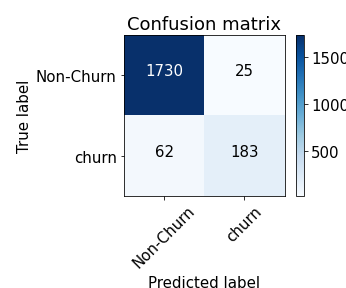

In [134]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(5, 4))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [135]:
roc_auc_score(y_test, preds)

0.9765800337228909

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки

1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk

In [169]:
  from itertools import product
  funcs = (np.median, np.max, np.mean)
  idfs = (0, 1)
  for our_idf in idfs:
    for func in funcs:
      user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, np_method=func, idf=our_idf), 1)])
      user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
      user_embeddings['uid'] = users['uid'].values
      user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
      user_embeddings
      target = pd.read_csv("users_churn.csv")
      X = pd.merge(user_embeddings, target, 'left')
      X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                          X['churn'], random_state=0)
      logreg = LogisticRegression()
      logreg.fit(X_train, y_train)
      preds = logreg.predict_proba(X_test)[:, 1]
      precision, recall, thresholds = precision_recall_curve(y_test, preds)
      epsilon = 10e-15 #искключаем случай когда precision и recall стали нулями одновременно.
      fscore = (2 * precision * recall) / (precision + recall + epsilon)
      ix = np.argmax(fscore)
      print(func.__name__, f'idf={bool(our_idf)}')
      print(
          f'Best Threshold={thresholds[ix]:.3f}, '
          f'F-Score={fscore[ix]:.3f}, '
          f'Precision={precision[ix]:.3f}, '
          f'Recall={recall[ix]:.3f}, '
          f'roc_auc_score={roc_auc_score(y_test, preds):.3f}\n'
      )

median idf=False
Best Threshold=0.209, F-Score=0.651, Precision=0.521, Recall=0.869, roc_auc_score=0.942

amax idf=False
Best Threshold=0.423, F-Score=0.811, Precision=0.880, Recall=0.751, roc_auc_score=0.977

mean idf=False
Best Threshold=0.210, F-Score=0.603, Precision=0.492, Recall=0.780, roc_auc_score=0.922

median idf=True
Best Threshold=0.401, F-Score=0.830, Precision=0.815, Recall=0.845, roc_auc_score=0.982

amax idf=True
Best Threshold=0.470, F-Score=0.739, Precision=0.756, Recall=0.722, roc_auc_score=0.965

mean idf=True
Best Threshold=0.350, F-Score=0.830, Precision=0.797, Recall=0.865, roc_auc_score=0.979



idf явно сработал в плюс для наших моделей, хотя в выборке почти нету статей которые бы читали много пользователей, тем не менее результаты значительно лучше.

idf = False:
    np.mean, np.median - дают слабые результаты так как они обьединяют статьи которые прочитал юзер, во что то среднее. добавляя шум.
    np.max - выделяет предпочтение, он показывает ради какой темы была открыта та или иная статья. а не "среднее по больнице". Есть ощущени, что если бы статей у каждого юзера было бы не 6, а силно больше то np.max стал бы хуже чем np.mean и np.median.

idf = True:
    тут сложно прокоментировать, np.median, и np.mean сильно подросли, а np.max упал. сложно сказать почему так произошло, и нету ли тут просто погрешности модели.

В середине ноутбука краткое описание создания idf